In [156]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [157]:
# Assuming merged_data_5 is the file path
merged_data_5 = 'merged_data_5.xlsx'

# Read data from Excel file into DataFrame
new_data = pd.read_excel(merged_data_5)

In [158]:
new_data.set_index('YearMonth', inplace=True)

In [159]:
new_data_copy = new_data[['RON 95', 'RON 97', 'DIESEL','selling_gold_price','buying_gold_price','Overnight_Interest_Rate']].copy()

In [160]:
new_data_copy

,RON 95,RON 97,DIESEL,selling_gold_price,buying_gold_price,Overnight_Interest_Rate
YearMonth,,,,,,
2017-03,2.13,2.41,2.11,5803.65,5566.04,3.00
2017-04,2.22,2.50,2.15,5944.58,5702.42,3.00
2017-05,2.08,2.36,2.01,5707.10,5480.76,3.00
2017-06,1.99,2.25,1.91,5730.11,5506.28,2.99
2017-07,1.98,2.23,1.96,5624.14,5406.38,2.98
...,...,...,...,...,...,...
2023-03,2.05,3.35,2.15,9048.91,8689.61,2.74
2023-04,2.05,3.35,2.15,9386.67,9014.83,2.74
2023-05,2.05,3.35,2.15,9536.10,9162.00,2.97


In [161]:
#################### hybrid modelling with 0.7 train data #######################

In [162]:
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(new_data_copy.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(new_data_copy.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['RON 95', 'RON 97', 'DIESEL','selling_gold_price','buying_gold_price','Overnight_Interest_Rate']] = target_scaler.fit_transform(new_data_copy[['RON 95', 'RON 97', 'DIESEL','selling_gold_price','buying_gold_price','Overnight_Interest_Rate']].to_numpy())
df_scaled = df_scaled.astype(float)

In [163]:
df_scaled

,RON 95,RON 97,DIESEL,selling_gold_price,buying_gold_price,Overnight_Interest_Rate
0,0.828571,0.263158,0.752941,0.136038,0.133133,0.843137
1,0.914286,0.291022,0.800000,0.168513,0.165848,0.843137
2,0.780952,0.247678,0.635294,0.113790,0.112675,0.843137
3,0.695238,0.213622,0.517647,0.119092,0.118797,0.836601
4,0.685714,0.207430,0.576471,0.094673,0.094833,0.830065
...,...,...,...,...,...,...
72,0.752381,0.554180,0.800000,0.883853,0.882424,0.673203
73,0.752381,0.554180,0.800000,0.961684,0.960439,0.673203
74,0.752381,0.554180,0.800000,0.996117,0.995742,0.823529
75,0.752381,0.560372,0.800000,1.000000,1.000000,0.836601


In [164]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['RON 95', 'RON 97', 'DIESEL','selling_gold_price','buying_gold_price','Overnight_Interest_Rate']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [165]:
# Dataset splitting
SPLIT = 0.8
(xVal, yVal) = singleStepSampler(df_scaled, 30)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [166]:
# Define the Hybrid LSTM-GRU Model
def build_hybrid_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(6, activation='linear'))
    return model

In [167]:
# Prepare the input shape from the training data
input_shape = (X_train.shape[1], X_train.shape[2])

In [168]:
# Build the model
model = build_hybrid_model(input_shape)

In [169]:
# Compile the model
model.compile(loss='mean_squared_error', metrics=['MAE'], optimizer='adam')

# Model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 80)            27840     
                                                                 
 gru_5 (GRU)                 (None, 30)                10080     
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 186       
                                                                 
Total params: 38106 (148.85 KB)
Trainable params: 38106 (148.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [170]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/7
2/2 [==============================] - 1s 234ms/step - loss: 0.3443 - MAE: 0.5214 - val_loss: 0.4072 - val_MAE: 0.6282
Epoch 2/7
2/2 [==============================] - 0s 15ms/step - loss: 0.2287 - MAE: 0.4135 - val_loss: 0.2388 - val_MAE: 0.4749
Epoch 3/7
2/2 [==============================] - 0s 17ms/step - loss: 0.1490 - MAE: 0.3221 - val_loss: 0.1249 - val_MAE: 0.3157
Epoch 4/7
2/2 [==============================] - 0s 15ms/step - loss: 0.1020 - MAE: 0.2547 - val_loss: 0.0640 - val_MAE: 0.1849
Epoch 5/7
2/2 [==============================] - 0s 16ms/step - loss: 0.0739 - MAE: 0.2168 - val_loss: 0.0440 - val_MAE: 0.1686
Epoch 6/7
2/2 [==============================] - 0s 17ms/step - loss: 0.0672 - MAE: 0.2144 - val_loss: 0.0446 - val_MAE: 0.1665
Epoch 7/7
2/2 [==============================] - 0s 16ms/step - loss: 0.0613 - MAE: 0.1922 - val_loss: 0.0583 - val_MAE: 0.1877


In [171]:
# Predict the test dataset
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 205ms/step


In [172]:
# Calculate RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Root Mean Squared Error: 0.24152755623328145
Mean Absolute Error: 0.18771959909295247
Mean Absolute Percentage Error: 0.2554435486492556


In [173]:
predicted_values = model.predict(X_test)

# Invert scaling for forecasted values
predicted_values_original = target_scaler.inverse_transform(predicted_values)

# Invert scaling for actual test values
actual_values_original = target_scaler.inverse_transform(y_test)

# Replacing scaled data with original data in the DataFrame
d_original = {
    'Predicted_RON_95': predicted_values_original[:, 0],
    'Predicted_RON_97': predicted_values_original[:, 1],
    'Predicted_DIESEL': predicted_values_original[:, 2],
    'Actual_RON_95': actual_values_original[:, 0],
    'Actual_RON_97': actual_values_original[:, 1],
    'Actual_DIESEL': actual_values_original[:, 2]
}

d_original = pd.DataFrame(d_original)
d_original.index = new_data_copy.index[-len(y_test):]  # Assigning the correct date index

1/1 [==============================] - 0s 8ms/step


In [174]:
d_original = d_original.round(2)
d_original

,Predicted_RON_95,Predicted_RON_97,Predicted_DIESEL,Actual_RON_95,Actual_RON_97,Actual_DIESEL
YearMonth,,,,,,
2022-10,2.11,2.88,2.29,2.05,3.95,2.15
2022-11,2.10,2.89,2.30,2.05,3.95,2.15
2022-12,2.10,2.90,2.31,2.05,3.57,2.15
2023-01,2.10,2.90,2.31,2.05,3.35,2.15
2023-02,2.10,2.90,2.32,2.05,3.35,2.15
2023-03,2.10,2.90,2.33,2.05,3.35,2.15
2023-04,2.10,2.90,2.33,2.05,3.35,2.15
2023-05,2.10,2.89,2.34,2.05,3.35,2.15
2023-06,2.11,2.89,2.35,2.05,3.37,2.15


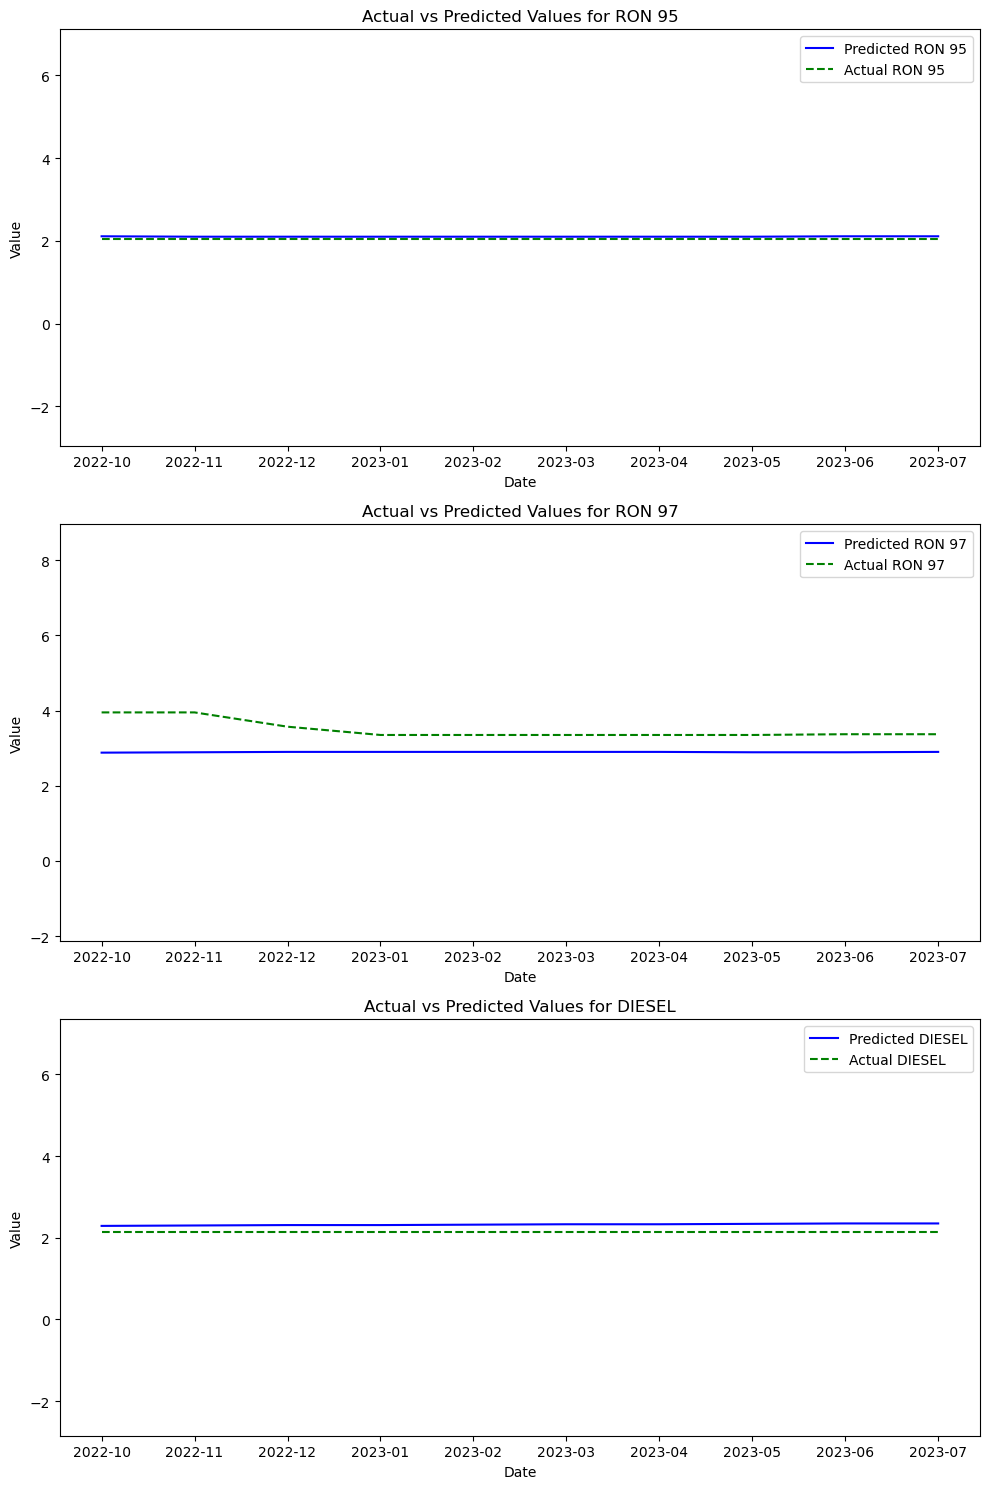

In [175]:
# Define the overall figure size
plt.figure(figsize=(10, 15))  # width, height in inches

# Plot for RON 95
plt.subplot(3, 1, 1)
plt.plot(d_original.index, d_original['Predicted_RON_95'], label='Predicted RON 95', color='blue')
plt.plot(d_original.index, d_original['Actual_RON_95'], label='Actual RON 95', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Values for RON 95')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.ylim([min(d_original['Actual_RON_95'].min(), d_original['Predicted_RON_95'].min()) - 5, 
          max(d_original['Actual_RON_95'].max(), d_original['Predicted_RON_95'].max()) + 5])  # Adjust y-limits

# Plot for RON 97
plt.subplot(3, 1, 2)
plt.plot(d_original.index, d_original['Predicted_RON_97'], label='Predicted RON 97', color='blue')
plt.plot(d_original.index, d_original['Actual_RON_97'], label='Actual RON 97', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Values for RON 97')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.ylim([min(d_original['Actual_RON_97'].min(), d_original['Predicted_RON_97'].min()) - 5, 
          max(d_original['Actual_RON_97'].max(), d_original['Predicted_RON_97'].max()) + 5])

# Plot for DIESEL
plt.subplot(3, 1, 3)
plt.plot(d_original.index, d_original['Predicted_DIESEL'], label='Predicted DIESEL', color='blue')
plt.plot(d_original.index, d_original['Actual_DIESEL'], label='Actual DIESEL', linestyle='dashed', color='green')
plt.title('Actual vs Predicted Values for DIESEL')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.ylim([min(d_original['Actual_DIESEL'].min(), d_original['Predicted_DIESEL'].min()) - 5, 
          max(d_original['Actual_DIESEL'].max(), d_original['Predicted_DIESEL'].max()) + 5])

plt.tight_layout()
plt.show()

In [176]:
###################### forecasting for future #########################

In [177]:
# Function to make recursive predictions
def forecast_future(model, input_data, n_steps):
    future_preds = []
    last_input = input_data
    for _ in range(n_steps):
        # Predict the next step
        next_pred = model.predict(last_input[np.newaxis, :, :])
        
        # Store the prediction
        future_preds.append(next_pred[0])
        
        # Update the last input to include the new prediction
        last_input = np.vstack([last_input[1:], next_pred])
    
    return np.array(future_preds)

In [178]:
# Ensure the index is a datetime type
if not pd.api.types.is_datetime64_any_dtype(new_data_copy.index):
    new_data_copy.index = pd.to_datetime(new_data_copy.index)

In [179]:
# Number of future steps to predict
n_future_steps = 12  # For 12 months

In [180]:
# Last available input data
last_input_data = X_test[-1]

In [181]:
# Generate future predictions
future_predictions = forecast_future(model, last_input_data, n_future_steps)

1/1 [==============================] - 0s 7ms/step


In [182]:
# Assuming you have a target_scaler from your initial scaling step
future_predictions_original = target_scaler.inverse_transform(future_predictions)

In [183]:
# Creating a DataFrame to store the future predictions with corresponding dates
future_dates = pd.date_range(start=new_data_copy.index[-1] + pd.DateOffset(months=1), periods=n_future_steps, freq='M')
future_df = pd.DataFrame(future_predictions_original, index=future_dates, columns=['RON 95', 'RON 97', 'DIESEL', 'selling_gold_price', 'buying_gold_price', 'Overnight_Interest_Rate'])

In [184]:
future_df= future_df.round(2)

In [185]:
future_df

,RON 95,RON 97,DIESEL,selling_gold_price,buying_gold_price,Overnight_Interest_Rate
2023-08-31,2.11,2.90,2.35,8687.150391,8716.129883,2.09
2023-09-30,2.11,2.89,2.36,8705.280273,8769.389648,2.08
2023-10-31,2.12,2.88,2.35,8715.450195,8812.309570,2.07
2023-11-30,2.13,2.87,2.35,8717.389648,8848.080078,2.06
2023-12-31,2.13,2.86,2.34,8714.209961,8878.769531,2.04
2024-01-31,2.14,2.85,2.34,8708.660156,8905.570312,2.03
2024-02-29,2.14,2.85,2.34,8702.870117,8929.269531,2.01
2024-03-31,2.14,2.85,2.33,8698.030273,8950.230469,2.00
2024-04-30,2.15,2.86,2.33,8694.669922,8968.700195,1.99
2024-05-31,2.15,2.87,2.33,8692.929688,8984.910156,1.98


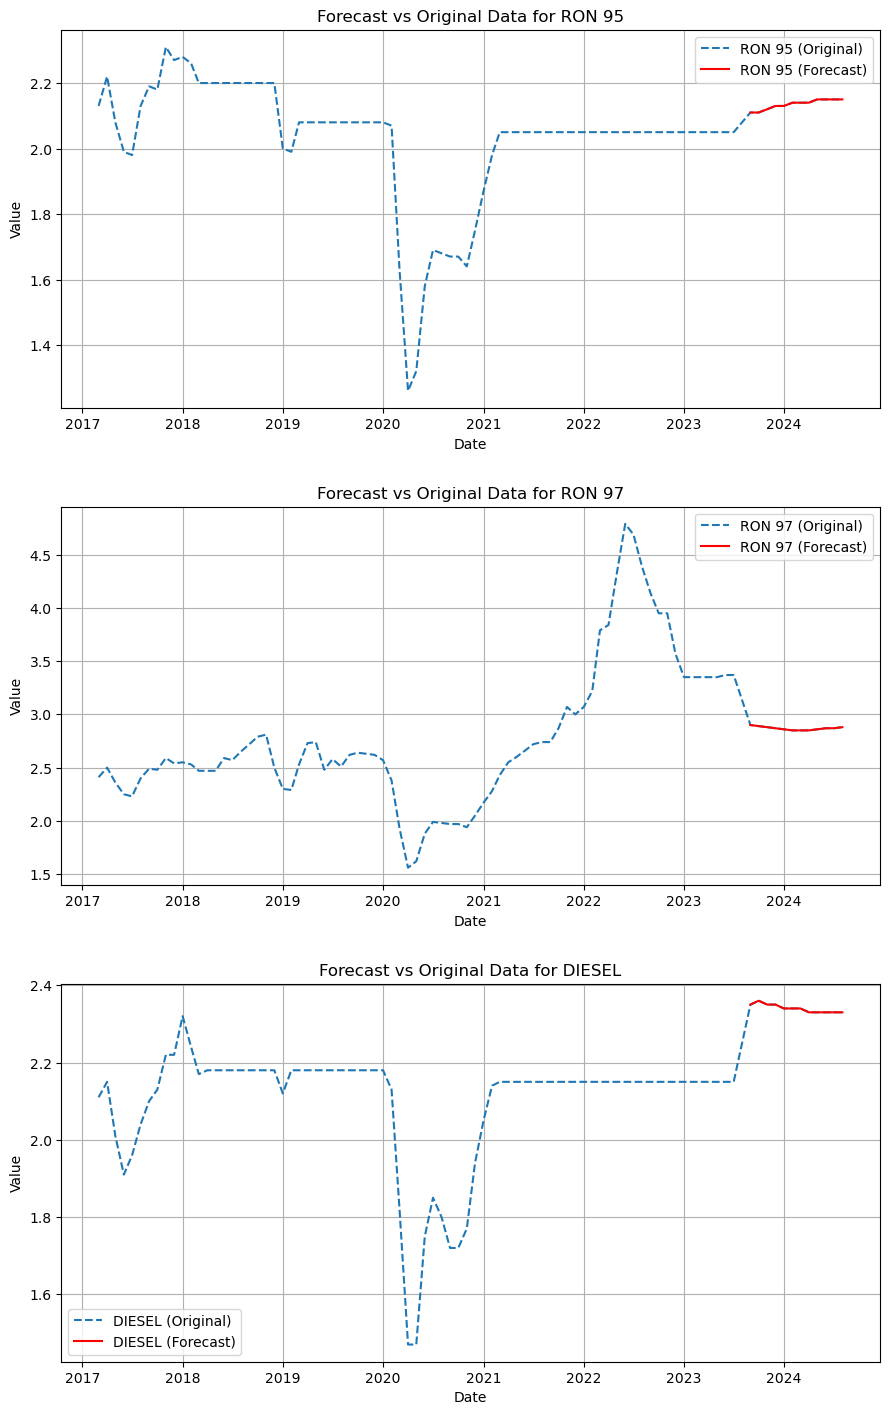

In [186]:
# Combine original and forecasted data into a single DataFrame
combined_df = pd.concat([new_data_copy, future_df])

# Define the figure for subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))  # 3 rows for three variables, each in a separate subplot
fig.tight_layout(pad=5.0)  # Adds space between plots

# Variables to plot
variables = ['RON 95', 'RON 97', 'DIESEL']

# Plotting each variable in a separate subplot
for i, var in enumerate(variables):
    # Plot original data
    axes[i].plot(combined_df.index, combined_df[var], label=var + ' (Original)', linestyle='dashed')
    
    # Plot forecasted data if available
    if var in future_df.columns:
        axes[i].plot(future_df.index, future_df[var], label=var + ' (Forecast)', color='red')
    
    axes[i].set_title(f'Forecast vs Original Data for {var}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True)

plt.show()